In [1]:
Project = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Projects/Adipocyte'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import copy

plt.rcParams.update(plt.rcParamsDefault)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

plt.rcParams['ps.useafm']=True
plt.rcParams['pdf.fonttype']=42

plt.rc('font', size=7)          # controls default text sizes
plt.rc('axes', titlesize=7)     # fontsize of the axes title
plt.rc('axes', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
plt.rc('legend', fontsize=6)    # legend fontsize
suptitlesize = 7

plt.rc('axes', axisbelow=True) #push axes to back
mpl.rcParams['axes.linewidth'] = 0.3

In [2]:
MitoCarta3_file = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/MITOCARTA3.0/Mouse.MitoCarta3.0.xls'
MitoCarta = pd.read_excel(MitoCarta3_file, 'A Mouse MitoCarta3.0')
MitoPW = pd.read_excel(MitoCarta3_file, 'C MitoPathways')

name2ID = MitoCarta[['Symbol','EnsemblGeneID']].set_index('Symbol')['EnsemblGeneID'].to_dict()

MitoPW['PW level'] = MitoPW['MitoPathway Hierarchy'].str.split('>').str.len()
MitoPW['gene_ids'] = ''
for i in range(len(MitoPW)):
    for gene in MitoPW.iloc[i,:]['Genes'].split(', '):
        if type(name2ID[gene]) == float : continue
        MitoPW['gene_ids'][i] += name2ID[gene].replace('|',',') + ','
    MitoPW['gene_ids'][i] = MitoPW['gene_ids'][i][:-1]
MitoPW = MitoPW.set_index('MitoPathway',drop=True)

mtDNA = MitoCarta[['Symbol','EnsemblGeneID']]
mtDNA = mtDNA[mtDNA['Symbol'].str.startswith('mt-')].reset_index(drop=True)
mtDNA = mtDNA.rename(columns={'Symbol':'gene_name', 'EnsemblGeneID':'gene_id'})[['gene_id']]

/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_27882/466202503.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MitoPW['gene_ids'][i] += name2ID[gene].replace('|',',') + ','
/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_27882/466202503.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MitoPW['gene_ids'][i] = MitoPW['gene_ids'][i][:-1]


In [3]:
OXPHOS_C = {f'C{n}' : pd.DataFrame({'gene_id' : MitoPW.loc[f'C{n} subunits','gene_ids'].split(',')}) for n in ['I','II','III','IV','V']}
# display(OXPHOS_C)

---

In [4]:
RD = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RD_avg_log2FC.tsv', sep='\t').drop(columns='gene_name')

table = {}
table['RD'] = RD

display(table['RD'])

,gene_id,D4,D8
0,ENSMUSG00000033845,-0.311108,-0.382188
1,ENSMUSG00000025903,0.143887,-0.212839
2,ENSMUSG00000033813,0.151689,0.189858
3,ENSMUSG00000033793,0.269876,0.283882
4,ENSMUSG00000025907,0.088801,-0.326082
...,...,...,...
11805,ENSMUSG00000064360,-0.227778,-2.407071
11806,ENSMUSG00000064363,-1.022871,-1.317163
11807,ENSMUSG00000064367,-0.418699,-0.569325
11808,ENSMUSG00000064368,-0.609004,-0.318614


In [5]:
RD = pd.read_csv(f'{Project}/Results/Other_papers/Reid_etal.2017.Scientific_Reports/Tables/Exp_calc/v20230826/Reid_RD_avg_log2FC.tsv', sep='\t').drop(columns='gene_name')

table['Reid_RD'] = RD

display(table['Reid_RD'])

,gene_id,RD_BD5,RD_WD5
0,ENSMUSG00000051951,-0.049704,1.780183
1,ENSMUSG00000033845,0.206629,-0.788247
2,ENSMUSG00000025903,-0.630639,0.424879
3,ENSMUSG00000033813,1.932815,0.017855
4,ENSMUSG00000033793,0.954542,-0.056810
...,...,...,...
9513,ENSMUSG00000065947,-2.424705,1.428417
9514,ENSMUSG00000064363,-1.118654,1.538492
9515,ENSMUSG00000064367,-1.112220,0.940620
9516,ENSMUSG00000064368,-1.764148,0.651865


In [6]:
CHIP = pd.read_csv('/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/GSEA/chip/Mouse_Ensembl_Gene_ID_MSigDB.v2022.1.Mm.chip', sep='\t', usecols=['Probe Set ID','Gene Symbol']).rename(columns={'Probe Set ID':'gene_id','Gene Symbol':'gene_name'})

In [7]:
data = pd.merge(table['RD'], table['Reid_RD'], on='gene_id', how='outer')
data = pd.merge(CHIP, data, on='gene_id')
mtDNA_data = pd.merge(mtDNA, data, on='gene_id', how='left')

data_dict = {}
for Cn in ['CI','CIII','CIV','CV']:
    data_dict[Cn] = pd.merge(mtDNA_data, OXPHOS_C[Cn], on='gene_id').sort_values('gene_name').reset_index(drop=True)

display(data_dict)

{'CI':               gene_id gene_name        D4        D8    RD_BD5    RD_WD5
 0  ENSMUSG00000064341    mt-Nd1 -1.224655 -0.870602 -1.594510  0.119571
 1  ENSMUSG00000064345    mt-Nd2 -0.804844 -0.706736 -1.455737  0.950851
 2  ENSMUSG00000064360    mt-Nd3 -0.227778 -2.407071 -1.815723  1.016652
 3  ENSMUSG00000064363    mt-Nd4 -1.022871 -1.317163 -1.118654  1.538492
 4  ENSMUSG00000065947   mt-Nd4l       NaN       NaN -2.424705  1.428417
 5  ENSMUSG00000064367    mt-Nd5 -0.418699 -0.569325 -1.112220  0.940620
 6  ENSMUSG00000064368    mt-Nd6 -0.609004 -0.318614 -1.764148  0.651865,
 'CIII':               gene_id gene_name        D4        D8    RD_BD5    RD_WD5
 0  ENSMUSG00000064370   mt-Cytb -0.913174 -1.297092 -0.872676  1.291038,
 'CIV':               gene_id gene_name        D4        D8    RD_BD5    RD_WD5
 0  ENSMUSG00000064351    mt-Co1 -0.876807 -0.632440 -0.142950  0.599900
 1  ENSMUSG00000064354    mt-Co2 -2.475190 -1.725733 -4.302278  1.304823
 2  ENSMUSG00000064358    mt

----

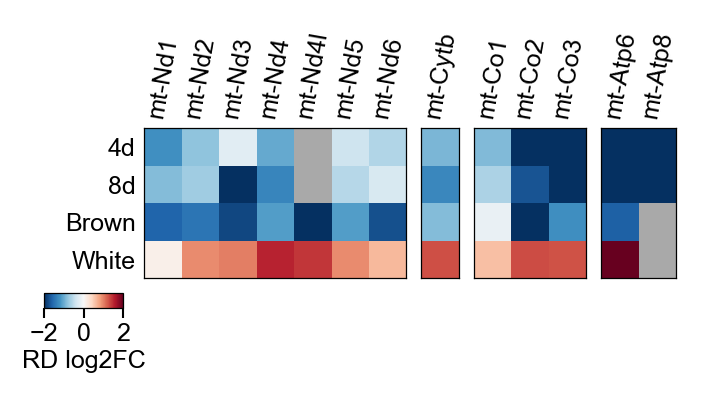

In [8]:
using_cm = copy.copy(mpl.colormaps.get_cmap("RdBu_r"))
using_cm.set_bad('darkgray',1.)

sF = 1 # Size factor
wgap = 0.05
hgap = 0.1
nrow, ncol = 1, len(data_dict)

width_ratios = np.array([len(data_dict[Cn])/4 for Cn in data_dict]) / 2
height_ratios = np.array([1]) / 2

fs_w = sum(np.array(width_ratios)*sF) + (ncol-1)*wgap*sF
fs_h = sum(np.array(height_ratios)*sF) + (nrow-1)*hgap*sF

#
fig = plt.figure(figsize=( fs_w, fs_h ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    width_ratios=width_ratios,
                    height_ratios=height_ratios,
                    wspace=wgap/np.average(width_ratios), 
                    hspace=hgap/np.average(height_ratios),
                    left=0, right=1, bottom=0, top=1)

row = 0
col = 0
for Cn in data_dict:
    ax = fig.add_subplot(grid[row,col])

    plot_data = data_dict[Cn].drop(columns='gene_id').set_index('gene_name', drop=True).T
    heat1 = ax.pcolormesh(plot_data[::-1],
                          cmap=using_cm, vmin=-2, vmax=2)

    ax.set_xticks([i+0.5 for i in range(len(plot_data.columns))])
    ax.set_yticks([]) 
    ax.set_xticklabels(plot_data.columns, rotation=80, ha='center')
    ax.tick_params(length=0, pad=2)
    # ax.tick_params(width=0.5, length=3, pad=1)
    ax.xaxis.tick_top()

    if col==0:
        ax.set_yticks([i+0.5 for i in range(len(plot_data))][::-1]) 
        ax.set_yticklabels(['4d','8d','Brown','White'])

        cbar = plt.colorbar(heat1, ax=ax, cax = ax.inset_axes([-0.38, -0.2, 0.3, 0.1]), orientation='horizontal')
        cbar.ax.set_xlabel('RD log2FC', labelpad=1, fontsize=6)
        cbar.ax.set_xticks([-2,0,2])
        cbar.ax.tick_params(width=0.5, length=2.5, pad=1)

    col+=1

plt.savefig('comp_mtDNA_RDlogFC_heatmap.pdf', bbox_inches='tight')
plt.show()
plt.close()